<h1>Klasifikasi Tumor Otak Pada Citra Dengan Menggunakan Ekstraksi Fitur GLCM

Kelompok 3 Pengenalan Pola


1.   Sania Nadlirotullubba (21/473170/PA/20368)
2.   Fayza Nizma Safaya Harda (21/474396/PA/20483)
3.   Jovinca Claudia Amarissa
4.   Maeve Zahwa Adriana Crown Zaki (21/477527/PA/20675)
5.   Vincent Yeozekiel
6.   Dicky Setiawan



In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.svm import SVCfrom sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

import warnings

#filter future warning message
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Preparation

> mengambil data dari kaggle lalu memasukkannya ke google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = 'drive/My Drive/Projek Akhir Pengenalan Pola Kelompok 3/pp-brain-tumor-detection'

Mounted at /content/drive


> membuat dan membaca metadata yang akan digunakan

In [ ]:
metadata = pd.DataFrame(columns=['image_path', 'segmented_image', 'label'])
metadata

,image_path,segmented_image,label


# Preprocessing dan Segmentation

> membuat fungsi untuk preprocessing ke grayscale dan image segmentation menggunakan metode otsu

In [ ]:
def segment_image(image):
  gray_image = rgb2gray(image)

  threshold = threshold_otsu(gray_image)
  segmented_image = gray_image > threshold

  return segmented_image

> memasukkan gambar-gambar dari folder no dan folder yes ke metadata setelah image di segmentasi

In [ ]:
no_folder = os.path.join(dataset_path, 'no')
no_images = os.listdir(no_folder)

for image_name in no_images:
  image_path = os.path.join(no_folder, image_name)
  image = plt.imread(image_path)
  image_shape = image.shape
  if (image_shape[-1] !=3 or len(image_shape) !=3):
      continue

  segmented_image = segment_image(image)
  metadata = metadata.append({'image_path': image_path, 'segmented_image': segmented_image, 'label': 'no'}, ignore_index=True)

In [ ]:
yes_folder = os.path.join(dataset_path, 'yes')
yes_images = os.listdir(yes_folder)

for image_name in yes_images:
  image_path = os.path.join(yes_folder, image_name)
  image = plt.imread(image_path)
  image_shape = image.shape
  if (image_shape[-1] !=3 or len(image_shape) !=3):
      continue

  segmented_image = segment_image(image)
  metadata = metadata.append({'image_path': image_path, 'segmented_image': segmented_image, 'label': 'yes'}, ignore_index=True)

> contoh dari hasil preprocessing 

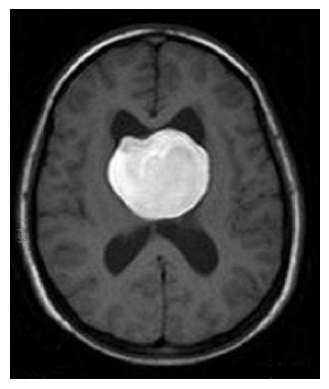

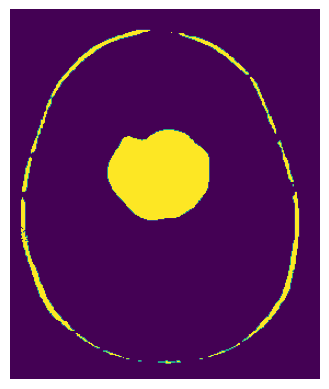

In [ ]:
#load salah satu gambar dari folder 'yes'
input_image_path = 'drive/My Drive/Projek Akhir Pengenalan Pola Kelompok 3/pp-brain-tumor-detection/yes/Y253.JPG'
input_image = plt.imread(input_image_path)

#menampilkan gambar
plt.imshow(input_image)
plt.axis('off')
plt.show()

#melakukan segmentasi
gray_image_uint = segment_image(input_image)

#menampilkan gambar yang telah di preprocessing
plt.imshow(gray_image_uint)
plt.axis('off')
plt.show()


In [ ]:
metadata

,image_path,segmented_image,label
0,drive/My Drive/Projek Akhir Pengenalan Pola Ke...,"[[False, False, False, False, False, False, Fa...",no
1,drive/My Drive/Projek Akhir Pengenalan Pola Ke...,"[[False, False, False, False, False, False, Fa...",no
2,drive/My Drive/Projek Akhir Pengenalan Pola Ke...,"[[True, False, False, True, True, True, True, ...",no
3,drive/My Drive/Projek Akhir Pengenalan Pola Ke...,"[[False, False, False, False, False, False, Fa...",no
4,drive/My Drive/Projek Akhir Pengenalan Pola Ke...,"[[False, False, False, False, False, False, Fa...",no
...,...,...,...
225,drive/My Drive/Projek Akhir Pengenalan Pola Ke...,"[[False, False, False, False, False, False, Fa...",yes
226,drive/My Drive/Projek Akhir Pengenalan Pola Ke...,"[[False, False, False, False, False, False, Fa...",yes
227,drive/My Drive/Projek Akhir Pengenalan Pola Ke...,"[[False, False, False, False, False, False, Fa...",yes
228,drive/My Drive/Projek Akhir Pengenalan Pola Ke...,"[[False, False, False, False, False, False, Fa...",yes


# Feature Extraction

> membuat fungsi untuk ekstaksi fitur dengan GLCM

In [ ]:
def extract_glcm_features(image):

  #jarak pasangan piksel yang akan digunakan dalam perhitungan GLCM adalah 1
  distances = [1]

  #sudut yang akan digunakan dalam perhitungan GLCM adalah 0, 45, 90, 135 derajat
  angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] 

  #menghitung glcm
  glcm = graycomatrix(image, distances, angles, levels=256, symmetric=True, normed=True)

  #menghitung properti dari glcm
  contrast = graycoprops(glcm, 'contrast').ravel()
  dissimilarity = graycoprops(glcm, 'dissimilarity').ravel()
  homogeneity = graycoprops(glcm, 'homogeneity').ravel()
  energy = graycoprops(glcm, 'energy').ravel()
  correlation = graycoprops(glcm, 'correlation').ravel()
  ASM = graycoprops(glcm, 'ASM').ravel()

  #representasi fitur dari gambar
  features = np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, ASM])
  return features

> Ekstraksi Fitur dari seluruh Gambar

In [ ]:
X = []
y = []

from skimage import color

for index, row in metadata.iterrows():
  segmented_image = row['segmented_image']

  features = extract_glcm_features(segmented_image)
  X.append(features)
  y.append(row['label'])

> mengonversi ke numpy array

In [ ]:
X = np.array(X)
y = np.array(y)

#Classification dan Analysis

> membagi dataset menjadi dua yaitu train dan test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

> 1. klasifikasi dan analisis dengan **algoritma SVM**



In [ ]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("SVM Accuracy:", accuracy)
print("SVM Confusion Matrix:")
print(conf_matrix)

SVM Accuracy: 0.7608695652173914
SVM Confusion Matrix:
[[ 0 11]
 [ 0 35]]


> 2. klasifikasi dan analisis dengan algoritma **K-nearest neighbors**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("K-nearest Neighbors Accuracy:", accuracy)
print("K-nearest Neighbors Confusion Matrix:")
print(conf_matrix)

K-nearest Neighbors Accuracy: 0.6956521739130435
K-nearest Neighbors Confusion Matrix:
[[ 7  4]
 [10 25]]


> 3. klasifikasi dan analisis dengan **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Decision Tree Accuracy:", accuracy)
print("Decision Tree Confusion Matrix:")
print(conf_matrix)

Decision Tree Accuracy: 0.6956521739130435
Decision Tree Confusion Matrix:
[[ 6  5]
 [ 9 26]]


> 4. klasifikasi dan analisis dengan **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Naive Bayes Accuracy:", accuracy)
print("Naive Bayes Confusion Matrix:")
print(conf_matrix)

Naive Bayes Accuracy: 0.7391304347826086
Naive Bayes Confusion Matrix:
[[ 5  6]
 [ 6 29]]


> 5. klasifikasi dan analisis dengan **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Random Forest Accuracy:", accuracy)
print("Random Forest Confusion Matrix:")
print(conf_matrix)
print("Random Forest Classification Report:")
print(classification_rep)

Random Forest Accuracy: 0.7608695652173914
Random Forest Confusion Matrix:
[[ 4  7]
 [ 4 31]]
Random Forest Classification Report:
              precision    recall  f1-score   support

          no       0.50      0.36      0.42        11
         yes       0.82      0.89      0.85        35

    accuracy                           0.76        46
   macro avg       0.66      0.62      0.64        46
weighted avg       0.74      0.76      0.75        46



#Memprediksi Kelas Tumor dari Gambar

dengan menggunakan pengklasifikasi yang paling tinggi akurasinya yaitu : Random Forest

kelas asli : **no**

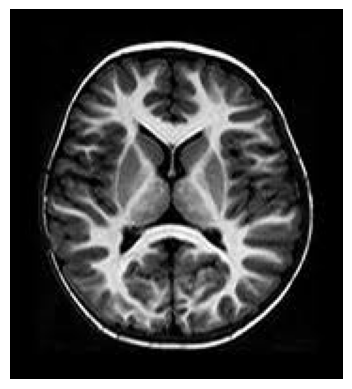

Predicted Class Label: no


In [ ]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops
from skimage.transform import resize
import numpy as np

#mengambil image dengan kelas asli 'no'
input_image_path = 'drive/My Drive/Projek Akhir Pengenalan Pola Kelompok 3/pp-brain-tumor-detection/no/14 no.jpg'
input_image = plt.imread(input_image_path)

#menampilkan image
plt.imshow(input_image)
plt.axis('off')
plt.show()

#preprocessing dan ekstraksi fitur
segmented_image = segment_image(input_image)
features = extract_glcm_features(segmented_image)

#mengubah fitur agar cocok dengan Random Forest Classifier
example_features = features.reshape(1, -1)

#memprediksi label
predicted_label = rf.predict(example_features)[0]

print("Predicted Class Label:", predicted_label)


kelas asli: **yes**

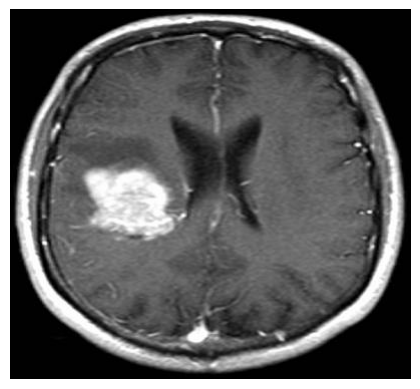

Predicted Class Label: yes


In [ ]:
#contoh jika input image untuk diprediksi kelasnya
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops
from skimage.transform import resize
import numpy as np

# Load and preprocess the input image
input_image_path = 'drive/My Drive/Projek Akhir Pengenalan Pola Kelompok 3/pp-brain-tumor-detection/yes/Y11.jpg'
input_image = plt.imread(input_image_path)

# Display the image
plt.imshow(input_image)
plt.axis('off')
plt.show()

#preprocessing dan ekstraksi fitur
segmented_image = segment_image(input_image)
features = extract_glcm_features(segmented_image)

#mengubah fitur agar cocok dengan Random Forest Classifier
example_features = features.reshape(1, -1)

#memprediksi label
predicted_label = rf.predict(example_features)[0]

print("Predicted Class Label:", predicted_label)
